# BERT with Sentiment analysis
In this notebook I used a pretrained version of BERT avaliable as a huggingface transformed to classify the sentiment of news articles about Bitcoin and Tesla, and applied an LSTM to predict the stock returns

### Sources

https://towardsdatascience.com/fine-tuning-bert-with-keras-and-tf-module-ed24ea91cff2 

* Bert for dummies: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
* Bert for long texts: https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d
* googles notebook: https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
* strong.io: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
* strong.io notebook : https://github.com/strongio/keras-bert

https://keras.io/layers/writing-your-own-keras-layers/

In [25]:
import tensorflow as tf
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from utils import *

In [777]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [977]:
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"

bitcoin = False
if not bitcoin:   
    stocks = ["TSLA"]
    keywords = {"TSLA": ["Tesla", "Elon Musk"]}
else:    
    stocks = ["BTC-USD"]
    keywords = {"BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
prices = df_financial["Close"]
prices = pd.DataFrame(data = prices, index = pd.date_range(start,end)).fillna(method = "bfill")

In [947]:
df_bitcoin = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df_tesla = pd.read_csv("csv/articles_Tesla-Elon_Musk_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df = df_bitcoin if bitcoin else df_tesla

In [1]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [790]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

### Split sentences

In [951]:
main_text = False
if main_text:
    # main_text
    text = df.maintext #pd.DataFrame(df.maintext.values, index = df["date_google"]).dropna()
    text.index = df["date_google"]
else:    
    # titles and descriptions
    titles = df.title
    titles.index = df["date_google"]
    descriptions = df.description
    descriptions.index = df["date_google"]
    text = pd.concat([titles,descriptions]).sort_index().dropna()
    
print(text.values[0])

Conor McGregor compared himself to Elon Musk in fiery exchange with Floyd Mayweather's manager


In [952]:
import nltk.data
split_sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [953]:
split_sentences = text.apply(split_sentence_tokenizer.tokenize)
split_sentences = split_sentences.groupby(split_sentences.index).sum()
split_sentences = pd.DataFrame(split_sentences)

In [954]:
df_ret = label_transformer(prices.copy(), shift = 1)

split_sentences, df_ret = series_intersection(split_sentences, df_ret)
raw_sentences, raw_labels = generate_data_for_tokenizer(split_sentences,df_ret)

lengths = raw_sentences.apply(lambda x: len(x[0].split()), axis = 1)
sentences = raw_sentences[(lengths > 10) & (lengths < 120)] #filter short and long sentences
labels = raw_labels[(lengths > 10) & (lengths < 120)]


In [957]:
keywords_bitcoin = ["crypto", "BTC", "bitcoin", "blockchain"]
keywords_tesla =   ["tesla", "Elon", "Musk", "TSLA"]
keys = keywords_bitcoin if bitcoin else keywords_tesla
raw_text = "".join(text.values).replace(".com","-com").replace(".", "").replace(",", "").replace("\n", " ").replace("-com",".com")
new_tokens = find_new_token_with_custom_keywords(raw_text, keys , 6, [])

New tokens to be added:  ['tesla', "tesla's", 'tesla’s', 'teslas', 'teslaelon', 'musktesla']


In [632]:
model = TFAutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", from_pt=True)


In [958]:
tokenizer.add_tokens(new_tokens)

5

In [661]:
example = "Bitcoin futures are trading below the cryptocurrency's spot price"
print(tokenizer.tokenize(example))
example_ids = tokenizer.encode(example)
print(example_ids)
output = model.predict([example_ids]) 
print("    1 star     2 stars     3 stars     4 stars     5 stars")
print(output[0])

['bitcoin', 'futures', 'are', 'trading', 'below', 'the', 'cryptocurrency', "'", 's', 'spot', 'price']
[101, 105879, 42272, 10320, 34948, 16934, 10103, 105880, 112, 161, 24311, 16993, 102]
    1 star     2 stars     3 stars     4 stars     5 stars
[[ 0.62086743  0.7408671   0.599566   -0.50914824 -1.2169912 ]]


In [102]:
example = "I am so disappointed with this product"
print(tokenizer.tokenize(example))
example_ids = tokenizer.encode(example)
print(example_ids)
output = model.predict([example_ids])
print("    1 star     2 stars    3 stars    4 stars    5 stars")
print(output[0])

['i', 'am', 'so', 'disa', '##ppo', '##inted', 'with', 'this', 'product']
[101, 151, 10345, 10297, 31021, 54894, 83912, 10171, 10372, 20058, 102]
    1 star     2 stars    3 stars    4 stars    5 stars
[[ 3.3838348   2.8609188   0.64698035 -2.613178   -3.5148153 ]]


In [959]:
encoded_sentences = sentences[0].apply(lambda x : tokenizer.encode(x))

In [960]:
predictions = encoded_sentences.apply(lambda x : model.predict([x])[0])

In [964]:
predictions.shape

(3186,)

In [972]:
avg_predictions.shape

(434, 5)

In [973]:
avg_predictions = predictions.groupby(predictions.index).apply(np.mean)
avg_predictions_array = np.array([a for a in avg_predictions.values])
shape = avg_predictions_array.shape
avg_predictions = pd.DataFrame(avg_predictions_array.reshape((shape[0], shape[2])), index = avg_predictions.index)
pd.to_pickle(avg_predictions, "sentiment_predictions_tesla_with_tokens")

In [520]:
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Sequential

In [773]:
def diff2p(d, start):
    prices = []
    cum_diff = start
    for diff in d:
        prices.append(diff + cum_diff)
        cum_diff += diff
    return prices

In [729]:
def r2p(d, start = 100):
    return start * (1 + d).cumprod()

In [380]:
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [403]:
def rolling_window_bert_2nd_dim(a, window):
    shape = (a.shape[0] - window + 1, window, a.shape[1])
    strides = (a.strides[0], a.strides[1]*a.shape[1], a.strides[1])
    #print(shape, strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [608]:
def lstm_model(n_steps):
    n_features = 5
    model = Sequential()
    model.add(LSTM(100, input_shape = (n_steps, n_features), return_sequences = True))
    model.add(TimeDistributed(Dense(20, activation='elu')))
    model.add(Flatten())
    model.add(Dense(1, activation='elu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [449]:
def dense_model():
    n_features = 5
    model = Sequential()
    #model.add(CuDNNLSTM(200, input_shape=(None, n_features), return_sequences= True))
    model.add(Input((n_features)))
    model.add(Dense(200))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [351]:
model = dense_model()
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs = 100)
pred_tr = model.predict(X_train)
pred_te = model.predict(X_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 200)               1200      
_________________________________________________________________
dropout_234 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0417 - val_loss: 0.0110
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0200 - val_loss: 0.0127
Epoch 3/100
12/12 [==========================

12/12 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 75/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 77/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 78/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 81/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 82/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 83/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 84/100


<ipython-input-700-fb24d58998c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Close"] = pred_prices_te


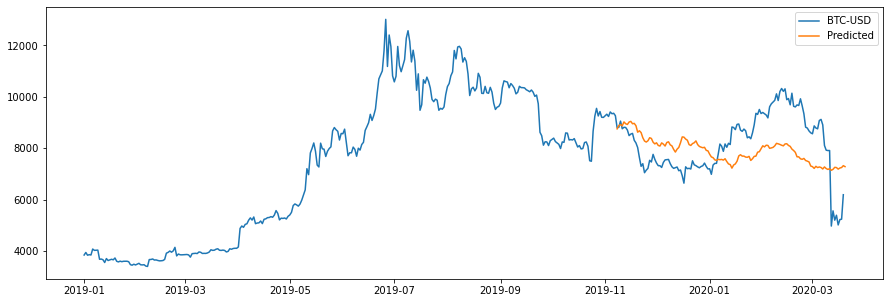

In [701]:

plt.figure(figsize = (15,5))
plt.plot(prices)
plt.plot(test)
plt.legend(["BTC-USD", "Predicted"])
plt.show()

In [911]:
def destandarize(data, mean, std):
    return data*std + mean

In [888]:
def standarize(data):
    return (data - data.mean())/data.std(), data.mean(), data.std()

In [927]:
def lstm_train_and_predict(X_train, X_test, y_train, y_test, window, standarize_output = False, mode = "returns", start = 100, epochs = 10):
    
    y_test_orig = y_test.values
    y_train_orig = y_train.values
    
    if standarize_output:
        y_test, y_test_mean, y_test_std = standarize(y_test)
        y_train, y_train_mean, y_train_std = standarize(y_train)
    
    X_train_roll = rolling_window_bert_2nd_dim(X_train.values, window)
    X_test_roll = rolling_window_bert_2nd_dim(X_test.values, window)
    y_train_roll = y_train[window - 1:].values
    y_test_roll = y_test[window - 1:].values
    
    lstm = lstm_model(window)
    history = lstm.fit(X_train_roll,y_train_roll, validation_data=(X_test_roll, y_test_roll), epochs = epochs)
    pred_tr = lstm.predict(X_train_roll)
    pred_te = lstm.predict(X_test_roll)
    
    if standarize_output:
        pred_tr = destandarize(pred_tr,y_train_mean, y_train_std)
        pred_te = destandarize(pred_te,y_test_mean, y_test_std)
        y_train_roll = destandarize(y_train_roll,y_train_mean, y_train_std)
        y_test_roll = destandarize(y_test_roll,y_test_mean, y_test_std)
    
    if mode == "returns":
        pred_prices_tr = r2p(pred_tr, start)
        pred_prices_te = r2p(pred_te, start)
        real_prices_tr = r2p(y_train_orig, start)
        real_prices_te = r2p(y_test_orig, start)
        
    if mode == "diff":
        pred_prices_tr = diff2p(pred_tr, start)
        pred_prices_te = diff2p(pred_te, start)
        real_prices_tr = diff2p(y_train_orig, start)
        real_prices_te = diff2p(y_test_orig, start)
    
    print("TEST DATA")
    plt.plot(real_prices_te)
    plt.plot(pred_prices_te)
    plt.legend(["y_real", "y_pred"])
    plt.show()


    print("TRAIN DATA")
    plt.plot(real_prices_tr)
    plt.plot(pred_prices_tr)
    plt.legend(["y_real", "y_pred"])
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.show()
    return lstm, pred_tr, pred_te
    

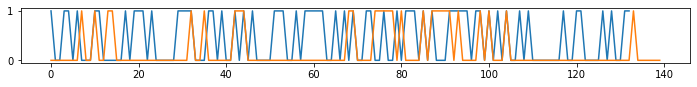

In [864]:
plt.figure(figsize = (12,1))
plt.plot(end)
plt.plot(np.append(np.array(7*[False]),p))
print(sum(p == end)/139)

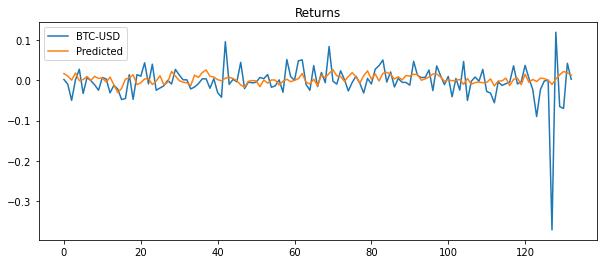

In [874]:
plt.figure(figsize = (10,4))
plt.plot(y_test.values[window - 1:])
plt.plot(pred_te.reshape(-1))
plt.legend(["BTC-USD", "Predicted"])
plt.title("Returns")
plt.show()

In [996]:
mode = "returns"
shift = 1
df_prices = label_transformer(prices.copy(), shift = shift, mode = mode)
avg_predictions, df_prices = series_intersection(avg_predictions, df_prices)

threshold = "2019-11-01"
X_train = avg_predictions.loc[:threshold]
X_test = avg_predictions.loc[threshold:]
y_train = df_prices.loc[:threshold]
y_test = df_prices.loc[threshold:]

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_157 (LSTM)              (None, 7, 100)            42400     
_________________________________________________________________
time_distributed_121 (TimeDi (None, 7, 20)             2020      
_________________________________________________________________
flatten_110 (Flatten)        (None, 140)               0         
_________________________________________________________________
dense_291 (Dense)            (None, 1)                 141       
Total params: 44,561
Trainable params: 44,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
10/10 [==============================] - 0s 38ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 2/15
10/10 [==============================] - 0s 6ms/step - loss: 6.9913e-04 - val_loss: 0.0018
Epoch 3/15
10/10 [======================

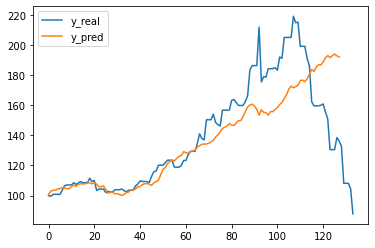

TRAIN DATA


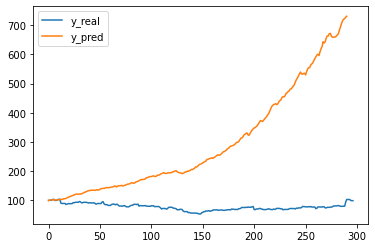

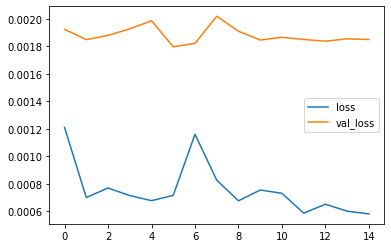

In [997]:
# window 7, 10 epochs, shift = 1
window = 7
ep = 15

lstm, pred_tr, pred_te = lstm_train_and_predict(X_train, X_test, y_train, y_test, window, 
                                                standarize_output = False, mode = mode,
                                                start = 100, epochs = ep)



<ipython-input-1000-50e30848c5ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Close"] = r2p(pred_te, start_price)


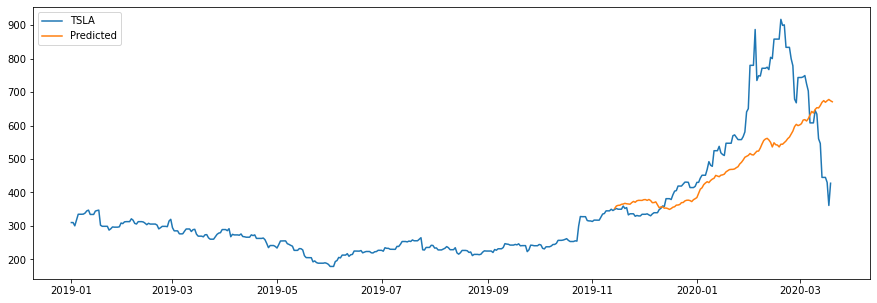

In [1000]:
plt.figure(figsize = (15,5))
plt.plot(prices)
index = pred_te.shape[0]
start_price = prices.iloc[-index][0]
test = prices.iloc[-index:]
test["Close"] = r2p(pred_te, start_price)
plt.plot(test)
plt.legend(["TSLA", "Predicted"])
plt.show()

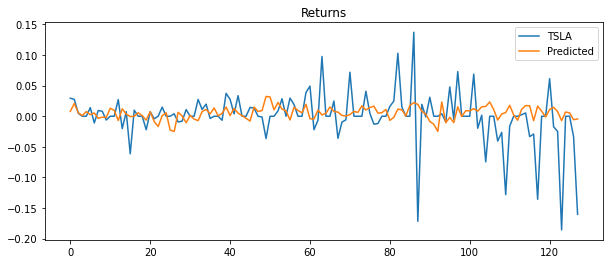

In [1002]:
plt.figure(figsize = (10,4))
plt.plot(y_test.values[window - 1:])
plt.plot(pred_te.reshape(-1))
plt.legend(["TSLA", "Predicted"])
plt.title("Returns")
plt.show()

In [ ]:
BEST
def lstm_model(n_steps):
    # create the LSTM model
    n_features = 5
    model = Sequential()
    model.add(LSTM(200, input_shape = (n_steps, n_features), return_sequences = True))
    model.add(LSTM(200))
    #model.add(Dense(50, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

def lstm_model(n_steps):
    n_features = 5
    model = Sequential()
    model.add(LSTM(200, input_shape = (n_steps, n_features), return_sequences = True))
    model.add(LSTM(200, return_sequences = True))
    model.add(TimeDistributed(Dense(50, activation='relu')))
    model.add(MaxPooling1D(pool_size = n_steps))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))    
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model